# DATA 620 - Final Project

Jeremy OBrien, Mael Illien, Vanita Thompson

## Topic Modeling and Network Analysis

### Introduction

A powerful analytical application of NLP is topic modeling, which identifies the themes present in a corpus comprised of multiple documents based on the words in those documents. Because it can be used to uncover the thematic structure in documents, topic modeling has an array of applications in information retrieval and document mining.

Topics are 'probability distributions over a fixed vocabulary'. It's common to use probabilistic generative models derived from LDA (Latent Dirichlet Allocation) to model in an unsupervised fashion the latent semantic structure of documents. Topic models can be tuned and optimized in a variety of ways, including improving how topics are segregated from each other and calibrating for a useful number of topics.

Network analysis provides techniques to understand the relationships between entitites, rendered as edges connecting nodes. In the case of NLP, it can be used to discover what topics are present in documents, or to analyze and visualize how documents are thematically related to each other.

### Research Question

In this project we attempt to combine techniques from topic modeling and network analysis to address this question:

*Given a text corpus comprised of multiple documents, what are the topics of those documents and how are the documents thematically related to one another?*

### Approach

- Leverage the Reuters news corpus of nearly 11,000 articles (labeled with at least one category each; unfortunately, authorship is not labeled)
- Using the NLTK, Spacy, Gensim packages, and MALLET packages, implement and tune an unsupervised LDA-based topic model (i.e. without reference to the provided article topic labels)
- Analyze topic model perplexity and coherence, overall topic prevalence, and topic distribution across articles
- Generate a graph of articles and topics, and analyze its topology to identify relationships between topics 

## Setup

In [1]:
import re
import random
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import numpy as np
np.random.seed(12321)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.corpus import reuters
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from nltk.corpus import reuters
from IPython.display import YouTubeVideo

## Data Import & Processing

### Data import and preliminary EDA

Per the NLTK Reuters README (accessible via `reuters.readme()`), this corpus include 10,788 article from the Reuters financial newswire service.  While it is partitioned into training and test sets, we will not be making use of these splits for this project.

In [2]:
# Generate dataframe of Reuters
news = []
for fileid in reuters.fileids():
    tag, filename = fileid.split('/')
    news.append((filename, tag, reuters.categories(fileid), reuters.raw(fileid)))
df = pd.DataFrame(news, columns=['Article', 'Tag', 'Category', 'Text'])

# Peek at Reuters data frame
df.head(5).apply(lambda x: x.str.slice(0, 125)).style.hide_index().hide_columns(['Tag'])

Article,Category,Text
14826,['trade'],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT Mounting trade friction between the U.S. And Japan has raised fears amon
14828,['grain'],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS A survey of 19 provinces and seven cities showed vermin consume between
14829,"['crude', 'nat-gas']",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry (MITI) will revise its
14832,"['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Thailand's trade deficit widened to 4.5 billion baht in the first quarter of 1
14833,"['palm-oil', 'veg-oil']",INDONESIA SEES CPO PRICE RISING SHARPLY Indonesia expects crude palm oil (CPO) prices to rise sharply to between 450 and


In [3]:
# Function to calculate category makeup of corpus
def category_count(df):
    
    cats = list(reuters.categories())
    cat_count = []
    
    # Count an article with multiple categories in tuple
    for cat in cats:
        cat_count.append(len(df[[cat in x for x in df['Category']]]))
    
    count_df = pd.DataFrame(cat_count, cats).reset_index()
    count_df.set_axis(['Category', 'Article Count'], axis=1, inplace=True)
    count_df.sort_values(by=['Article Count'], ascending=False, inplace=True)
    count_df.reset_index(drop=True, inplace=True)
    count_df['Percentage'] = count_df['Article Count'] / count_df['Article Count'].sum()
    
    return count_df

article_props = category_count(df)
display(article_props.head(n=10))
display(article_props.tail(n=10))
print('Categories with less than 1% of all articles: ', len(article_props[article_props['Percentage'] < .01]))
print('Categories with less than .1% of all articles: ', len(article_props[article_props['Percentage'] < .001]))

,Category,Article Count,Percentage
0,earn,3964,0.297419
1,acq,2369,0.177746
2,money-fx,717,0.053797
3,grain,582,0.043667
4,crude,578,0.043367
5,trade,485,0.036390
6,interest,478,0.035864
7,ship,286,0.021459
8,wheat,283,0.021233
9,corn,237,0.017782


,Category,Article Count,Percentage
80,palladium,3,0.000225
81,palmkernel,3,0.000225
82,copra-cake,3,0.000225
83,dfl,3,0.000225
84,cotton-oil,3,0.000225
85,sun-meal,2,0.000150
86,groundnut-oil,2,0.000150
87,rye,2,0.000150
88,lin-oil,2,0.000150
89,castor-oil,2,0.000150


Categories with less than 1% of all articles:  74
Categories with less than .1% of all articles:  28


The corpus is labeled with 90 different categories. Each article can be labelled with multiple categories (e.g. 'trade' and 'ship').

There is considerable category skew and a pronounced long tail: 'earn' (29.7%) and 'acq' (17.7%) represent nearly half the articles in the corpus, while 74 categories have less than 1% of all articles, and 28 have less than .1%. 

However, given LDA is unsupervised and these labels aren't used, category skew does not impact the performance of topic modeling.

### Text preparation and tokenization

LDA aims to describe document collections by assigning topics based on the those documents' word frequency.  To do this the words must be demarcated and standardized for lexical analysis.

We remove characters, diacritics, and punctuation, and convert all text to lower case tokens.

In [4]:
# Convert text to list
data = df['Text'].values.tolist()

# Remove new line characters and single quotes
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]

# Function to tokenize words and remove punctuation
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sentence_to_words(data))

# Impact of text preparation
print('\nOriginal text: \n', (df.iloc[330,3][:300]))
print('\nAfter cleaning: \n', data[330][:300])
print('\nAfter tokenization: \n', data_words[330][:30])


Original text: 
 G-7 ISSUES STATEMENT AFTER MEETING
  Following is the text of a statement
  by the Group of Seven -- the U.S., Japan, West Germany, France,
  Britain, Italy and Canada -- issued after a Washington meeting
  yesterday.
      1. The finance ministers and central bank governors of
  seven major industr

After cleaning: 
 G-7 ISSUES STATEMENT AFTER MEETING Following is the text of a statement by the Group of Seven -- the U.S., Japan, West Germany, France, Britain, Italy and Canada -- issued after a Washington meeting yesterday. 1. The finance ministers and central bank governors of seven major industrial countries me

After tokenization: 
 ['issues', 'statement', 'after', 'meeting', 'following', 'is', 'the', 'text', 'of', 'statement', 'by', 'the', 'group', 'of', 'seven', 'the', 'japan', 'west', 'germany', 'france', 'britain', 'italy', 'and', 'canada', 'issued', 'after', 'washington', 'meeting', 'yesterday', 'the']


### Pre-processing and feature engineering

Stopwords are abundant in English. Their high frequency provides very little information to inform topic modeling, so we remove them from the tokens.

In [5]:
# Function to remove stopwords
def remove_stopwords(texts):
    
    # Identify stopwords using NLTK and amend
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

Some adjacent words are known to convey different meaning.  We associate  these words in pairs called bigrams, and add them to the tokens.

In [6]:
# Function to make bigrams
def make_bigrams(texts):
    
    # Generate bigram model
    bigram = gensim.models.Phrases(data_words, 
                                   min_count=5, # must occur at least five times in corpus to be counted
                                   threshold=100)  # higher threshold fewer phrases
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return [bigram_mod[doc] for doc in texts]

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

Words are inflected when their use in speech changes due to 'tense, case, voice, aspect, person, number, gender, and mood'  ([Wikipedia](https://en.wikipedia.org/wiki/Inflection)).  These inflections in nouns (declension) and verbs (conjugation) can take the form of prefixes, suffixes, or infixes.  **Stemming** uses an algorithmic approach that is more approximate than **lemmatization**, which uses dictionaries to identify root forms.

We lemmatize the tokens to normalize them for topic modeling.

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    # https://spacy.io/api/annotation
    
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

# MI: do we use the nlp variable below anywhere?

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Perform lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[0][:30])

['asian', 'exporter', 'fear', 'damage', 'mount', 'trade', 'friction', 'raise', 'fear', 'many', 'asia', 'export', 'nation', 'row', 'could', 'inflict', 'far', 'reach', 'economic', 'damage', 'businessman', 'official', 'say', 'tell', 'asian', 'capital', 'move', 'may', 'boost', 'protectionist_sentiment']


We create a dictionary representation of the tokens in the corpus, calculating the term document frequency for each token.  With this, we can proceed with topic modeling.

In [8]:
# Create dictionary representation of corpus
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus with term document frequency
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

## Topic Model Training

We generate a topic model for the corpus of article, employing two approaches:

1. Gensim's built-in LDA topic modeling function, `ldamodel`.  Gensim implementations of LDA employ Variational Inference, which introduces bias and can provide less coherence in topics.
2. MALLET (MAchine Learning for LanguagE Toolkit)'s LDA topic model with a Gensim wrapper, `ldamallet`.  This model employs Gibbs sampling (an MCMC method), which is unbiased at the cost of heavy computation (performed in Java).

LDA models can be evaluated based on several different metrics:

- **Perplexity** is a [measure](https://en.wikipedia.org/wiki/Perplexity) of 'surprise', or how well the model predicts.  The lower the score, the better the prediction.
- **Coherence** is the degree of 'semantic similarity between high scoring keywords in the topic' (['Learn to Find Topics in a Text Corpus'](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)).  It is computed as a the sum of pairwise scores of the top n words by frequency.  The higher the coherence, the more coherent and interpretable the topic. 

Selecting the number of topics in an LDA model can be an arbitrary decision. We inform this decision through hyperparameter tuning based on an evaluation of the topic coherence yielded by different numbers of topics. We optimize the Gensim and MALLET LDA models accordingly.

In [9]:
# Function to generate Gensim LDA model
def gensim_ldamodel(corpus, num_topics):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                               id2word=id2word,  # dictionary
                                               num_topics=num_topics,  # to be optimized
                                               random_state=100,  # [JO: CONFIRM]
                                               # update_every=1,  # how often paramater should be updated
                                               # chunksize=100,
                                               # passes=10,  # total number of training passes
                                               # alpha='auto',  # learn assymetric alpha from training data (JO: consider whether to evaluate symmetric approach for alpha with asymmetric for beta)
                                               per_word_topics=True)
    
    return model

# Function to generate MALLET LDA model
def mallet_ldamodel(corpus, num_topics):
    
    mallet_path = './mallet-2.0.8/bin/mallet' 
    
    model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                        corpus=corpus, 
                                        num_topics=num_topics,
                                        random_seed=100,
                                        id2word=id2word)
    
    return model

# Function to iterate over numbers of topics and calculates LDA model coherence
def compute_coherence_values(model_type, dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    coherence='c_v'
    
    for num_topics in range(start, limit, step):
        
        if model_type == 'LdaModel':
            model = gensim_ldamodel(corpus=corpus,
                           num_topics=num_topics)
            
        elif model_type == 'LdaMallet':
            model = mallet_ldamodel(corpus=corpus,
                                    num_topics=num_topics)
            
        else:
            print('model_type not supported')
            break
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=id2word, 
                                        coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values  # List of LDA topic models and coherence values for respective number of topics

# Function to support decision on optimal number of topics
def chart_model_coherence(coherence_values, limit, start=2, step=3):
    
    x = range(start, limit, step)
    
    coherence_table = pd.DataFrame(list(zip(x,coherence_values)), columns=['Num Topics','Coherence Score'])
    
    plt.plot(x, coherence_values)
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()
    
    return coherence_table

### Gensim LDA model

#### Tuning Number of Topics

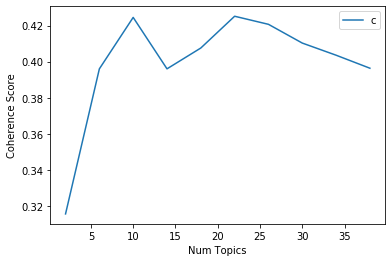

,Num Topics,Coherence Score
0,2,0.315559
1,6,0.396004
2,10,0.424539
3,14,0.396019
4,18,0.407569
5,22,0.425183
6,26,0.420701
7,30,0.410306
8,34,0.403574
9,38,0.396359


In [10]:
# Cast broad net to find neighborhood of optimal number of topics in range of 2 to 40 in steps of 4
gs_broad_model_list, gs_broad_coherence_values = compute_coherence_values(model_type='LdaModel',
                                                                          dictionary=id2word, 
                                                                          corpus=corpus, 
                                                                          texts=data_lemmatized, 
                                                                          start=2, 
                                                                          limit=40, 
                                                                          step=4)

# Chart broad net of optimal number of topics
chart_model_coherence(gs_broad_coherence_values, 
                      start=2, 
                      limit=40, 
                      step=4)

When analyzed at 4 topic steps, Gensim LDA model coherence peaks between 6 and 25 topics.  It's not very smooth, so given that 4 topic increments spikes could be obscuring the optimum we narrow our search in that range with 1 topic steps.

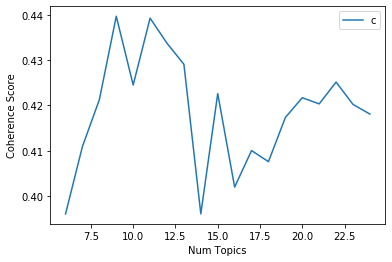

,Num Topics,Coherence Score
0,6,0.396004
1,7,0.410933
2,8,0.421290
3,9,0.439753
4,10,0.424539
5,11,0.439331
6,12,0.433781
7,13,0.429110
8,14,0.396019
9,15,0.422628


In [11]:
# Cast narrower net in range of 6 to 25 in single steps to smooth and find optimum in number of topics
gs_narrow_model_list, gs_narrow_coherence_values = compute_coherence_values(model_type='LdaModel',
                                                                            dictionary=id2word, 
                                                                            corpus=corpus, 
                                                                            texts=data_lemmatized, 
                                                                            start=6, 
                                                                            limit=25, 
                                                                            step=1)

# Chart narrower net of optimal number of topics
gs_narrow_coherence = chart_model_coherence(gs_narrow_coherence_values, 
                      start=6, 
                      limit=25, 
                      step=1)     
gs_narrow_coherence

#### Optimized Gensim Model

9 topics yield the highest coherence score so we select that model. Here is a snapshot of top words for each of the 9 topics in this model.

In [14]:
# Optimal Gensim model
# gs_optimal_model = gs_narrow_model_list[int(gs_narrow_coherence.loc[gs_narrow_coherence['Coherence Score'].idxmax()]['Num Topics'])]
gs_optimal_model = gensim_ldamodel(corpus=corpus, num_topics=9)

# Compute model perplexity and coherence score
print('\nGensim LDA model perplexity: ', gs_optimal_model.log_perplexity(corpus))
# print('\nGensim LDA model coherence score: ', gs_narrow_coherence.loc[gs_narrow_coherence['Coherence Score'].idxmax()]['Coherence Score'])
print('\nGensim LDA model coherence score: ', CoherenceModel(model=gs_optimal_model, texts=texts).get_coherence(), '\n')

# Here is a quick look at the the top words by topic for the optimal Gensim model
for topic_id in range(gs_optimal_model.num_topics):
    top_k = gs_optimal_model.show_topic(topic_id, 10)
    top_k_words = [w for w, _ in top_k]
    
    print('{}: {}'.format(topic_id, ' '.join(top_k_words)))


Gensim LDA model perplexity:  -7.095693898256886

Gensim LDA model coherence score:  0.43975307826479676 

0: say year rate rise quarter expect growth first earning increase
1: price say oil raise crude trader barrel today dlrs rate
2: say crop year deficit soybean estimate last trade surplus program
3: say company share offer would buy stock group also sell
4: say bank market rise dollar rate dealer money yen currency
5: loss net ct profit dlrs sale year say include note
6: say trade would export official government import country year japanese
7: share ct say dividend stock record split dlrs may pay
8: say year oil price production last would rise market export


### MALLET LDA model

We replicate the steps from above to the MALLET topic model. As mentioned, the MALLET is computationally heavy yet we expect to have more coherent topics as a compromise. We start by sweeping the number of topics as a parameter from 2 to 20 and build all the intermediate models. From there we can focus on the are of the coherence plot below which has the high coherence and narrow in further to identify the optimal number of topics for this model on this corpus. 

#### Tuning Number of Topics

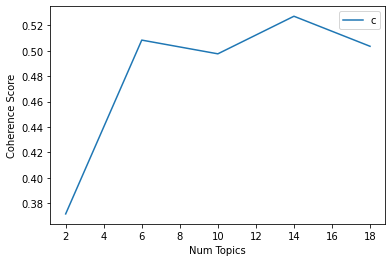

,Num Topics,Coherence Score
0,2,0.371488
1,6,0.508364
2,10,0.497556
3,14,0.527151
4,18,0.503495


In [22]:
# Cast broad net to find neighborhood of optimal number of topics in range of 2 to 40 in steps of 4
mlt_broad_model_list, mlt_broad_coherence_values = compute_coherence_values(model_type='LdaMallet',
                                                                          dictionary=id2word, 
                                                                          corpus=corpus, 
                                                                          texts=data_lemmatized, 
                                                                          start=2, 
                                                                          limit=20, 
                                                                          step=4)

# Chart broad net of optimal number of topics
chart_model_coherence(mlt_broad_coherence_values, 
                      start=2, 
                      limit=20, 
                      step=4)

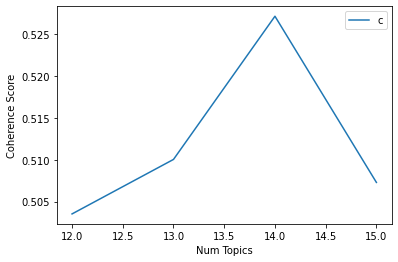

,Num Topics,Coherence Score
0,12,0.503529
1,13,0.510041
2,14,0.527151
3,15,0.507292


In [23]:
# Cast narrower net in range of 12 to 16 in single steps to smooth and find optimum in number of topics
mlt_narrow_model_list, mlt_narrow_coherence_values = compute_coherence_values(model_type='LdaMallet',
                                                                            dictionary=id2word, 
                                                                            corpus=corpus, 
                                                                            texts=data_lemmatized, 
                                                                            start=12, 
                                                                            limit=16, 
                                                                            step=1)

# Chart narrower net of optimal number of topics
mlt_narrow_coherence = chart_model_coherence(mlt_narrow_coherence_values, 
                      start=12, 
                      limit=16, 
                      step=1)     
mlt_narrow_coherence

#### Optimized MALLET Model

From the sweep optimization above, we were able to determine that the optimal number of topics for this model is 14. We save this model as a variable for future use and take a look at the keyword distribution of the topics.

In [24]:
# Optimal MALLET model
mlt_optimal_model = mallet_ldamodel(corpus=corpus, num_topics=14)

# Compute model perplexity and coherence score
print('\nMallet LDA model perplexity: ', gs_optimal_model.log_perplexity(corpus))
print('\nMallet LDA model coherence score: ', CoherenceModel(model=mlt_optimal_model, texts=texts).get_coherence(), '\n')

# Here is a quick look at the the top words by topic for the optimal MALLET model
for topic_id in range(mlt_optimal_model.num_topics):
    top_k = mlt_optimal_model.show_topic(topic_id, 10)
    top_k_words = [w for w, _ in top_k]
    
    print('{}: {}'.format(topic_id, ' '.join(top_k_words)))


Mallet LDA model perplexity:  -7.095664176983087

Mallet LDA model coherence score:  0.5271508282605067 

0: price agreement meeting producer market talk agree member coffee set
1: sale company unit earning business quarter result operation sell complete
2: year dlrs end expect report early total month period week
3: ct loss net profit dlrs note include mln gain sale
4: rise fall year growth increase deficit show figure decline month
5: oil price production crude increase industry barrel contract raise gold
6: tonne export wheat import grain crop program corn estimate production
7: bank interest tax debt loan payment credit capital increase issue
8: offer company make plan group merger bid tender propose proposal
9: spokesman state today official source government ship strike work day
10: share stock company common dividend acquire record shareholder cash pay
11: trade official government japanese country import foreign industry economic policy
12: buy analyst firm market investment s

One could look at these keywords and derive a description based on their human knowledge. For example, topic 6 is clearly about agriculture and grain/wheat exports. Topic 5 is clearly about oil. 

There is enough diversity in these keywords for new labels to be assigned based on further analysis.

## Topic Model Analysis & Visualization

### Most Dominant Topics

The most dominant topics in each article are extracted using both optimal models. These will be used in a comparison against the known labels of the Reuters corpus. Along with the dominant topics, we also extract the keywords associated with the topics and the measure of how likely the dominant topic was.

The function below is used to obtain the proportion of articles that have been assigned a particular topic by the model. 

In [25]:
# Returns a dataframe of the proportion of articles having a particular topic
def get_topic_distribution(best_topics_df):
    
    topic_count = best_topics_df.groupby(['Best Topic','Keywords'])['Article'].count()
    topic_prop = pd.DataFrame(topic_count/len(best_topics_df)*100)
    topic_prop = topic_prop.reset_index()
    topic_prop.columns = ['Best Topic', 'Keywords', 'Proportion']
    topic_prop['Proportion'] = topic_prop['Proportion'].apply(lambda x: round(x,2)) # Look into truncating digits
    
    return topic_prop

#### Best Gensim Topics

In [26]:
# Function to extract best topic for each article along with associate keywords and likelyhood
def get_best_gensim_topics(lda_model, corpus):
    
    lda_model_corpus = lda_model[corpus]
    art_topic_keywords = pd.DataFrame(columns = ['Article','Best Topic','Likelihood','Keywords'])
    
    # Loop through articles to get each article's main topic
    for i, article in enumerate(lda_model[corpus]):
        for article in enumerate(article): 
            if article[0] == 0:
                #print(article)
                wp = lda_model.show_topic(article[1][0][0])
                topic_keywords = ', '.join([word for word, prop in wp])
                
                best_topic = int(article[1][0][0])
                max_likelihood = round(article[1][0][1],4)
                
                d = {'Article': i, 'Best Topic': best_topic,'Likelihood': max_likelihood,'Keywords': topic_keywords}
                art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)

    return art_topic_keywords

In [43]:
gensim_topic_df = get_best_gensim_topics(gs_optimal_model, corpus)

gensim_topic_df.head(10).style.hide_index()

Article,Best Topic,Likelihood,Keywords
0,0,0.077400,"say, year, rate, rise, quarter, expect, growth, first, earning, increase"
1,2,0.073000,"say, crop, year, deficit, soybean, estimate, last, trade, surplus, program"
2,8,0.988400,"say, year, oil, price, production, last, would, rise, market, export"
3,0,0.634600,"say, year, rate, rise, quarter, expect, growth, first, earning, increase"
4,6,0.048400,"say, trade, would, export, official, government, import, country, year, japanese"
5,6,0.990400,"say, trade, would, export, official, government, import, country, year, japanese"
6,2,0.074200,"say, crop, year, deficit, soybean, estimate, last, trade, surplus, program"
7,2,0.618400,"say, crop, year, deficit, soybean, estimate, last, trade, surplus, program"
8,8,0.977200,"say, year, oil, price, production, last, would, rise, market, export"
9,0,0.172700,"say, year, rate, rise, quarter, expect, growth, first, earning, increase"


The dataframe above displays the most likely topic along with the likelihood of that topic. The keywords that describe the topics are also shown. When aggregated in the data frame below, topic 0 emerges as the most common topic with 45% of the articles classified as such. Topics 3 and 5 round out the top 3 of topics represent in more than 10% of the articles.

Interestingly, the word 'say' is repeated in a lot of these topics. This is an anomaly to keep in mind.

In [29]:
gs_topic_prop = get_topic_distribution(gensim_topic_df)
gs_topic_prop.style.hide_index().background_gradient(subset='Proportion',cmap='Blues')

Best Topic,Keywords,Proportion
0,"say, year, rate, rise, quarter, expect, growth, first, earning, increase",45.570000
1,"price, say, oil, raise, crude, trader, barrel, today, dlrs, rate",7.650000
2,"say, crop, year, deficit, soybean, estimate, last, trade, surplus, program",7.430000
3,"say, company, share, offer, would, buy, stock, group, also, sell",19.070000
4,"say, bank, market, rise, dollar, rate, dealer, money, yen, currency",4.250000
5,"loss, net, ct, profit, dlrs, sale, year, say, include, note",11.080000
6,"say, trade, would, export, official, government, import, country, year, japanese",2.410000
7,"share, ct, say, dividend, stock, record, split, dlrs, may, pay",1.260000
8,"say, year, oil, price, production, last, would, rise, market, export",1.290000


#### Best Mallet Topics

In [30]:
# Function to extract best topic for each article along with associate keywords and likelyhood
def get_best_mallet_topics(lda_model, corpus):
    
    lda_model_corpus = lda_model[corpus]
    art_topic_keywords = pd.DataFrame(columns = ['Article','Best Topic','Likelihood','Keywords'])
    
    for i in range(len(lda_model_corpus)):
        # Get article topic model distribution
        article = lda_model_corpus[i]

        # Find the max likelihood index and select the corresponding topic
        likelihood = [likelyhood for topic,likelyhood in article]
        max_likelihood = max(likelihood)
        best_topic = likelihood.index(max_likelihood)
        
        # Get keywords for best topcis
        wp = lda_model.show_topic(best_topic)
        topic_keywords = ', '.join([word for word, prop in wp])
        
        # Assemble and append information to dataframe
        d = {'Article': i, 'Best Topic': best_topic,'Likelihood': max_likelihood,'Keywords': topic_keywords}
        art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)
        
    return art_topic_keywords
    

In [31]:
mallet_topic_df = get_best_mallet_topics(mlt_optimal_model, corpus)

mallet_topic_df

,Article,Best Topic,Likelihood,Keywords
0,0,11,0.470864,"trade, official, government, japanese, country..."
1,1,6,0.167488,"tonne, export, wheat, import, grain, crop, pro..."
2,2,5,0.265873,"oil, price, production, crude, increase, indus..."
3,3,4,0.258730,"rise, fall, year, growth, increase, deficit, s..."
4,4,6,0.249664,"tonne, export, wheat, import, grain, crop, pro..."
...,...,...,...,...
10783,10783,13,0.107672,"rate, market, dollar, bank, exchange, currency..."
10784,10784,3,0.105121,"ct, loss, net, profit, dlrs, note, include, ml..."
10785,10785,3,0.105121,"ct, loss, net, profit, dlrs, note, include, ml..."
10786,10786,3,0.289449,"ct, loss, net, profit, dlrs, note, include, ml..."


When using the MALLET model, the porportions are a lot more diversified which makes sense given the increased number of topics (from 9 to 14).

Topic 3 makes up for 21% of the articles with keywords like: 'ct', 'loss', 'net', 'profit', 'dlrs', 'note', 'include', 'mln', 'gain', and 'sale'. We can recognize these as words from financial reports. 

Topic 10 with 12% is the second most represented with keywords: 'share', 'stock', 'company', 'common', 'dividend', 'acquire', 'record', 'shareholder', 'cash', and 'pay'. Interestingly, while there is no overlap in the words, the theme of company and financial report are very similar. Topic 10 seems more related to earnings report with keywords like 'shareholder' and 'dividend'.

In [32]:
mallet_topic_prop = get_topic_distribution(mallet_topic_df)
mallet_topic_prop.style.hide_index().background_gradient(subset='Proportion',cmap='Blues')

Best Topic,Keywords,Proportion
0,"price, agreement, meeting, producer, market, talk, agree, member, coffee, set",4.410000
1,"sale, company, unit, earning, business, quarter, result, operation, sell, complete",9.380000
2,"year, dlrs, end, expect, report, early, total, month, period, week",3.190000
3,"ct, loss, net, profit, dlrs, note, include, mln, gain, sale",21.210000
4,"rise, fall, year, growth, increase, deficit, show, figure, decline, month",6.150000
5,"oil, price, production, crude, increase, industry, barrel, contract, raise, gold",6.730000
6,"tonne, export, wheat, import, grain, crop, program, corn, estimate, production",7.370000
7,"bank, interest, tax, debt, loan, payment, credit, capital, increase, issue",3.550000
8,"offer, company, make, plan, group, merger, bid, tender, propose, proposal",6.720000
9,"spokesman, state, today, official, source, government, ship, strike, work, day",3.650000


## Topic Comparison

#### Verification

We can verify the relevance of the keywords generated from our topic models and the known labels against the actual text. For example, with the first text of the corpus labeled with the `trade` category the related topic keywords for the topic models are:

- Gensim: 'say', 'year', 'rate', 'rise', 'quarter', 'expect', 'growth', 'first', 'earning', 'increase' (topic 0: 45% of articles are related)
- MALLET: 'trade', 'official', 'government', 'japanese', 'country', 'import', 'foreign', 'industry', 'economic', 'policy' (topic 11: 4.8% of articles are related)

This tells us that the MALLET model is able to discern topics particularly related to japanese trade. In the case of the article below, this is spot on as is evident from the first couple of sentences. On the other hand, the Gensim model groups this article in a topic not specific to Japan.

Across Gensim topics, there is a notable repetition of the word 'say'. This is likely the result of articles quoting sources or referencing others; however, given it does not contribute specific information to each topic and is common across them it should have been filtered out by the topic model.

In [37]:
# Create summary dataframe with keywords from each model vs known categories
summary_df = pd.concat([df['Category'], gensim_topic_df['Keywords'], mallet_topic_df['Keywords']], axis=1, sort=False)
summary_df.columns = ['Reuters categories','Gensim keywords','MALLET keywords']

In [38]:
summary_df

,Reuters categories,Gensim keywords,MALLET keywords
0,[trade],"say, year, rate, rise, quarter, expect, growth...","trade, official, government, japanese, country..."
1,[grain],"say, crop, year, deficit, soybean, estimate, l...","tonne, export, wheat, import, grain, crop, pro..."
2,"[crude, nat-gas]","say, year, oil, price, production, last, would...","oil, price, production, crude, increase, indus..."
3,"[corn, grain, rice, rubber, sugar, tin, trade]","say, year, rate, rise, quarter, expect, growth...","rise, fall, year, growth, increase, deficit, s..."
4,"[palm-oil, veg-oil]","say, trade, would, export, official, governmen...","tonne, export, wheat, import, grain, crop, pro..."
...,...,...,...
10783,"[interest, money-fx]","say, bank, market, rise, dollar, rate, dealer,...","rate, market, dollar, bank, exchange, currency..."
10784,[earn],"say, year, rate, rise, quarter, expect, growth...","ct, loss, net, profit, dlrs, note, include, ml..."
10785,[earn],"say, year, rate, rise, quarter, expect, growth...","ct, loss, net, profit, dlrs, note, include, ml..."
10786,[earn],"say, company, share, offer, would, buy, stock,...","ct, loss, net, profit, dlrs, note, include, ml..."


In [40]:
print(df.iloc[0,3][:1000])

ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually halt exports

#### Best Model

Based on the maximum coherence achieved of 0.527, we select the optimal MALLET model for further use in network analysis in the following section. The occurrence of the word 'say' across most Gensim topic keywords make us suspicious of its power of discernment and further justifies our choice of the MALLET model.

In [41]:
# Print chosen dataframe to csv file
mallet_topic_df.to_csv('mallet_df.csv', index=False) 

## Network Analysis

- Expecting a disconnected graph with num_topics central nodes with edges to articles. 
- Get the top 5 largest subgraphs which represent the most common topics (degree centrality)
- From the most popular topics, suggest next 5 articles to read by looking at edge weight (likelyhood).

In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
from itertools import product
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings

In [2]:
# Import data using pandas
url = 'https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/ProjectFinal/mallet_df.csv'
ratings = pd.read_csv(url)
ratings

,Article,Best Topic,Likelihood,Keywords
0,0,11,0.470864,"trade, official, government, japanese, country..."
1,1,6,0.167488,"tonne, export, wheat, import, grain, crop, pro..."
2,2,5,0.265873,"oil, price, production, crude, increase, indus..."
3,3,4,0.258730,"rise, fall, year, growth, increase, deficit, s..."
4,4,6,0.249664,"tonne, export, wheat, import, grain, crop, pro..."
...,...,...,...,...
10783,10783,13,0.107672,"rate, market, dollar, bank, exchange, currency..."
10784,10784,3,0.105121,"ct, loss, net, profit, dlrs, note, include, ml..."
10785,10785,3,0.105121,"ct, loss, net, profit, dlrs, note, include, ml..."
10786,10786,3,0.289449,"ct, loss, net, profit, dlrs, note, include, ml..."


In [3]:
# Separate and pivot CSV mallet list keywords
mov_actlist2 = ratings[['Best Topic', 'Keywords']]
mov_act2 = mov_actlist2.applymap(lambda x: [x]) # Convert to list for cartesian product
mov_act2['Keywords'] = mov_actlist2['Keywords'].apply(lambda x: x.split(','))
mov_act2 = pd.DataFrame([j for i in mov_act2.values for j in product(*i)], columns=['Best_Topic', 'Keywords'])
mov_act2.head(n=10).style.hide_index()

Best_Topic,Keywords
11,trade
11,official
11,government
11,japanese
11,country
11,import
11,foreign
11,industry
11,economic
11,policy


This is an overview of most popular(used) keywords from the best topics in the reuters corpus, which was mined with mallet and importd for analysis.

### Visualization

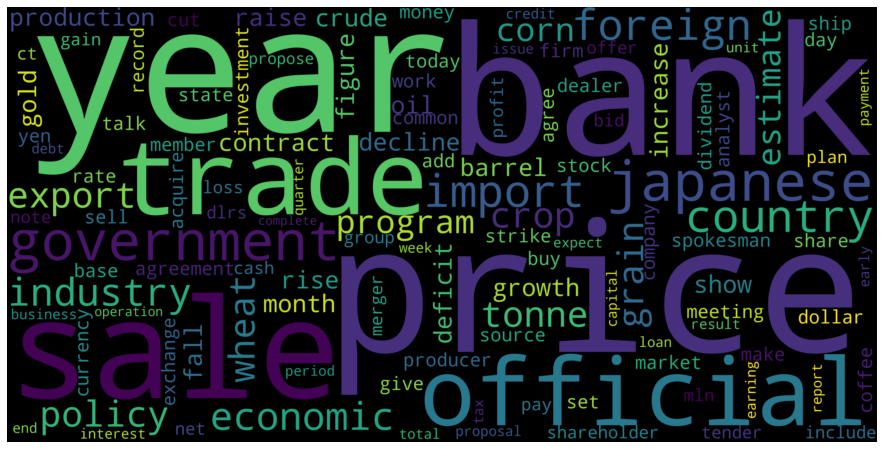

In [4]:
#Overview most popular words in mallet_df 'Keywords'
import wordcloud
from wordcloud import WordCloud

# Create a wordcloud of the movie titles
movie_titles_dedupe = mov_act2['Keywords'].drop_duplicates()
movie_titles = movie_titles_dedupe.fillna("").astype('str')
title_corpus = ' '.join(movie_titles)
title_wordcloud = WordCloud(background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud,interpolation='bilinear')
plt.axis('off');

Here, we take a look at the most frequently used keywords in the corpus.

In [5]:
# Frequency of keyword apperances in the mallet_df 
word_freq = pd.DataFrame(mov_act2.Keywords.str.split(expand=True).stack().value_counts())

In [6]:
#reset index, rename columns, format
word_freq.reset_index(level=0, inplace=True)
word_freq.columns = ['keywords','frequency']
word_freq['frequency'] = word_freq['frequency'].apply(pd.to_numeric)

In [7]:
#view result
word_freq.head(20)

,keywords,frequency
0,sale,3300
1,company,3041
2,dlrs,2632
3,net,2288
4,mln,2288
5,ct,2288
6,include,2288
7,profit,2288
8,note,2288
9,gain,2288


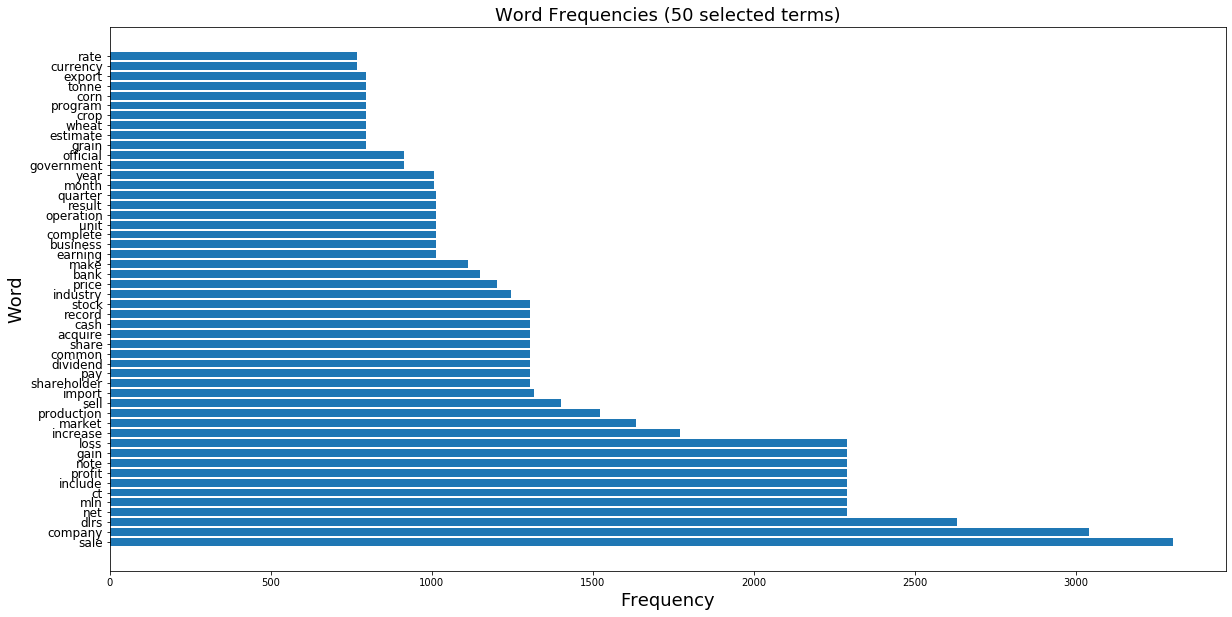

In [8]:
plt.figure(figsize=(20,10))
# this is for plotting purpose
index = np.arange(len(word_freq['keywords'][:50]))
plt.barh(index, word_freq['frequency'][:50])
plt.ylabel('Word', fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.yticks(index, word_freq['keywords'][:50], fontsize=12, rotation=0)
plt.title('Word Frequencies (50 selected terms)',fontsize=18)
plt.show()

### Bipartite Representation

In [10]:
G_full2= nx.from_pandas_edgelist(mov_act2,'Best_Topic','Keywords')
G_full2.graph['name'] = 'Full bipartite graph'

In [11]:
print(nx.info(G_full2))

Name: Full bipartite graph
Type: Graph
Number of nodes: 139
Number of edges: 140
Average degree:   2.0144


We check for connected components.

In [12]:
s = 'Graph is bipartite: {} \nGraph is connected: {} \nNumber of connected components {}'
print(s.format(nx.is_bipartite(G_full2), nx.is_connected(G_full2), nx.number_connected_components(G_full2)))

Graph is bipartite: True 
Graph is connected: False 
Number of connected components 2


In [13]:
# Identify connected components with greater than five nodes
sorted([len(c) for c in nx.connected_components(G_full2)], reverse=True)

[79, 60]

In [14]:
# Function to extract subgraphs
def get_subgraphs(graph):
    
    subgraphs = [(graph.subgraph(c),len(c)) for c in nx.connected_components(graph)] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

# Create connected subgraphs and confirm
subgraphs = get_subgraphs(G_full2)
print(*subgraphs[:5], '\n', sep='\n')

# Isolate the largest subgraph
largest_subg = subgraphs[0][0]
largest_subg.graph['name'] = 'Main bipartite subgraph'
print(nx.info(largest_subg), "\n")

# Verify largest subgraph is bipartite
G = largest_subg
print('Graph is bipartite: {} \nGraph is connected: {} \n'.format(nx.is_bipartite(G), nx.is_connected(G)))

(<networkx.classes.graphviews.SubGraph object at 0x000001C6D9EB6288>, 79)
(<networkx.classes.graphviews.SubGraph object at 0x000001C6D9EB2508>, 60)


Name: Main bipartite subgraph
Type: SubGraph
Number of nodes: 79
Number of edges: 80
Average degree:   2.0253 

Graph is bipartite: True 
Graph is connected: True 



Name: Main bipartite subgraph
Type: SubGraph
Number of nodes: 79
Number of edges: 80
Average degree:   2.0253 



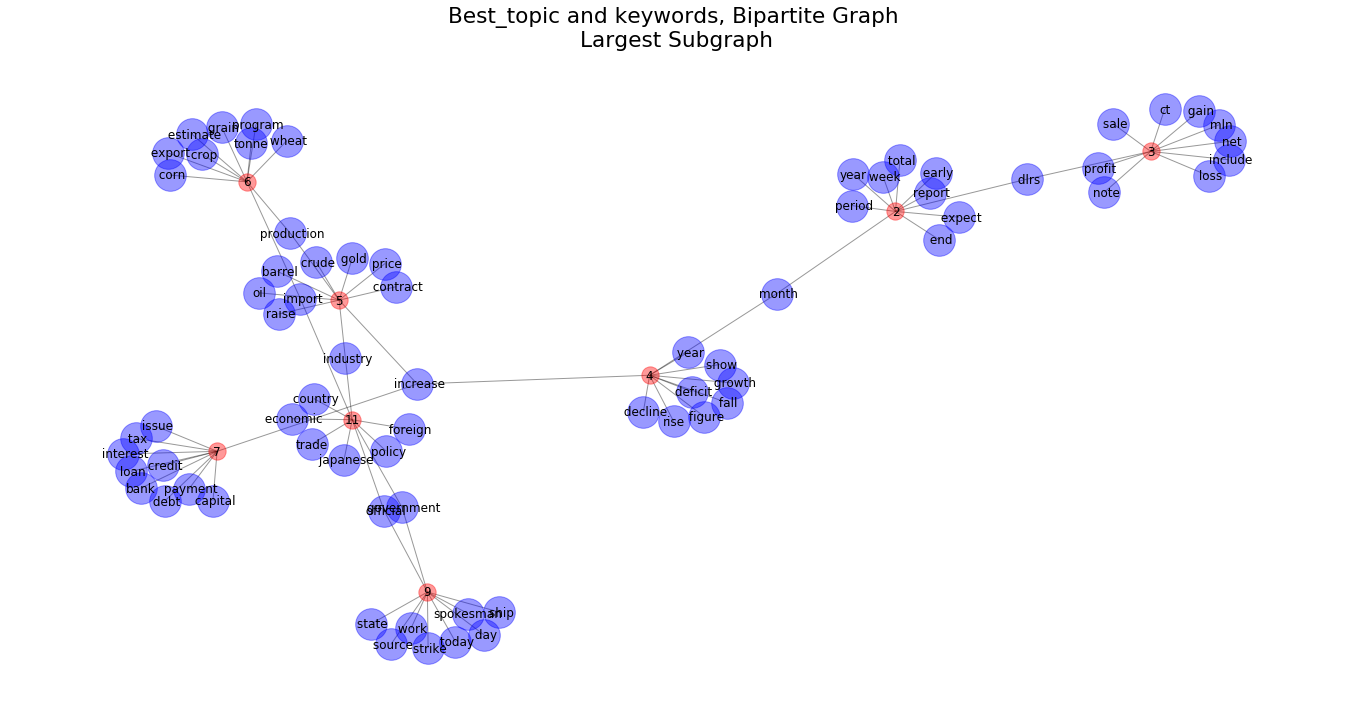

In [16]:
# Function to visualize 2-mode network
def plot_bipartite(graph, title):
    
    # Display graph summary stats
    print(nx.info(graph), '\n')
    
    # Apply plot settings
    warnings.filterwarnings('ignore')
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = (24,12)
    plt.axis('off')
    pos = nx.spring_layout(graph)
    plt.title(title)
    
    # Source node labels
    best_topic, keywords = nx.bipartite.sets(graph)
    
    # Plot graph by node type
    nx.draw_networkx_nodes(graph, pos, nodelist=best_topic, node_color='red', alpha = 0.4)
    nx.draw_networkx_nodes(graph, pos, nodelist=keywords, node_color='blue', alpha = 0.4, node_size = 1000)
    nx.draw_networkx_edges(graph, pos, alpha = 0.4)
    nx.draw_networkx_labels(graph, pos);

# Plot the largest subgraph
title = 'Best_topic and keywords, Bipartite Graph \nLargest Subgraph'
plot_bipartite(G, title)

### Unipartite Representations

In [17]:
# Function to extract unipartite graph from bipartite graph and plot it
def convert_bipartite_plot_unipartite(graph, title):
    
    # Display graph summary stats
    print(nx.info(graph), '\n')
    
    # Set node color
    if graph.graph['name'] == 'Best_Topic':
        node_color = 'blue'
    elif graph.graph['name'] == 'Keywords':
        node_color = 'red'
    else: 
        node_color = 'r'
    
    # Apply plot settings
    warnings.filterwarnings('ignore')
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = (24,12)
    plt.axis('off')
    pos = nx.spring_layout(graph)
    plt.title(title)
    
    # Calculate edge weights and node size
    weights = [edata['weight'] for f,t,edata in graph.edges(data=True)]
    node_size = [graph.degree(v)*100 for v in graph] #sizes nodes according to connectedness in first iteration
    
    # Plot graph by node type
    nx.draw_networkx(graph, 
                     k=0.1,
                     iterations=20, 
                     node_size=node_size,
                     node_color=node_color,
                     width=weights, 
                     edge_color=weights,
                     alpha=0.7)
    plt.show()

In [18]:
Best_Topic, Keywords = nx.bipartite.sets(G)

Best_Topic = bipartite.weighted_projected_graph(G, Best_Topic, ratio=False)
Best_Topic.graph['name'] = 'Best Topic'

Keywords = bipartite.weighted_projected_graph(G, Keywords, ratio=False)
Keywords.graph['name'] = 'Keywords'

Name: Best Topic
Type: Graph
Number of nodes: 8
Number of edges: 9
Average degree:   2.2500 



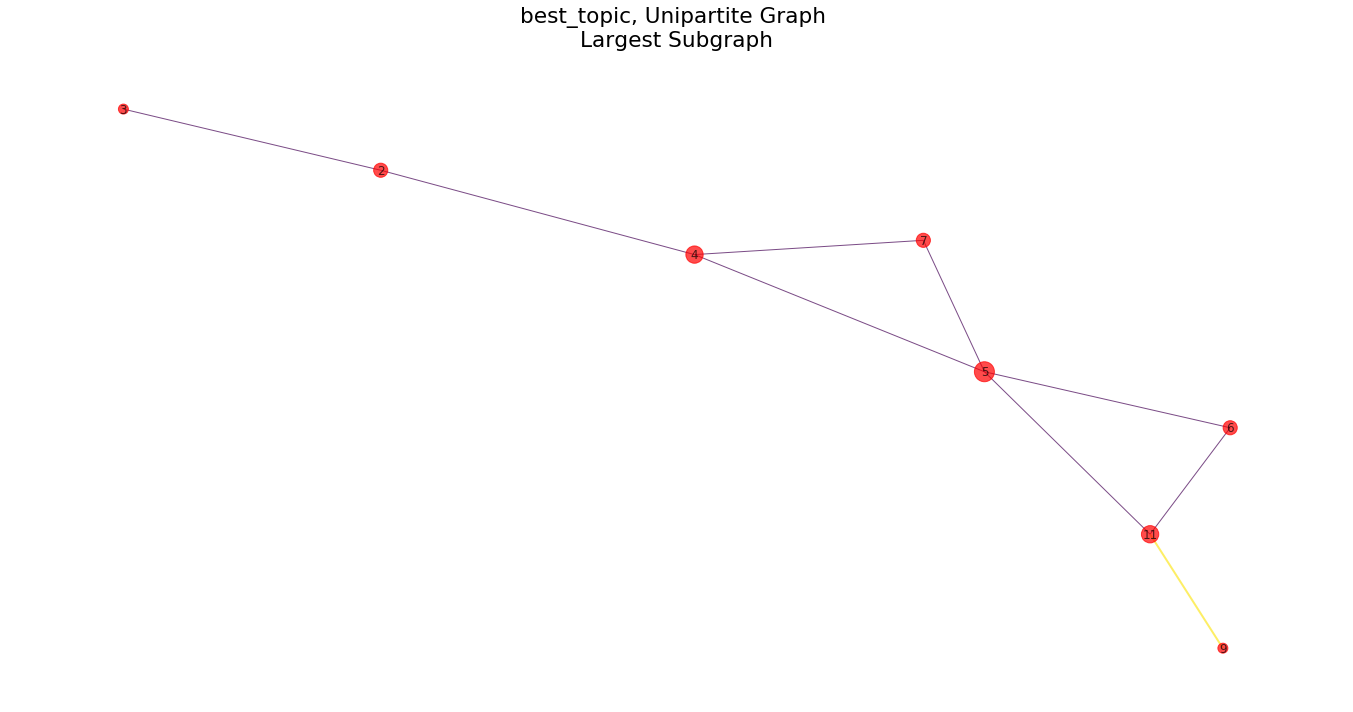

In [19]:
# Visualize the unipartite graph to identify relationships between best topics
title = 'best_topic, Unipartite Graph \nLargest Subgraph'
convert_bipartite_plot_unipartite(Best_Topic, title)

Name: Keywords
Type: Graph
Number of nodes: 71
Number of edges: 359
Average degree:  10.1127 



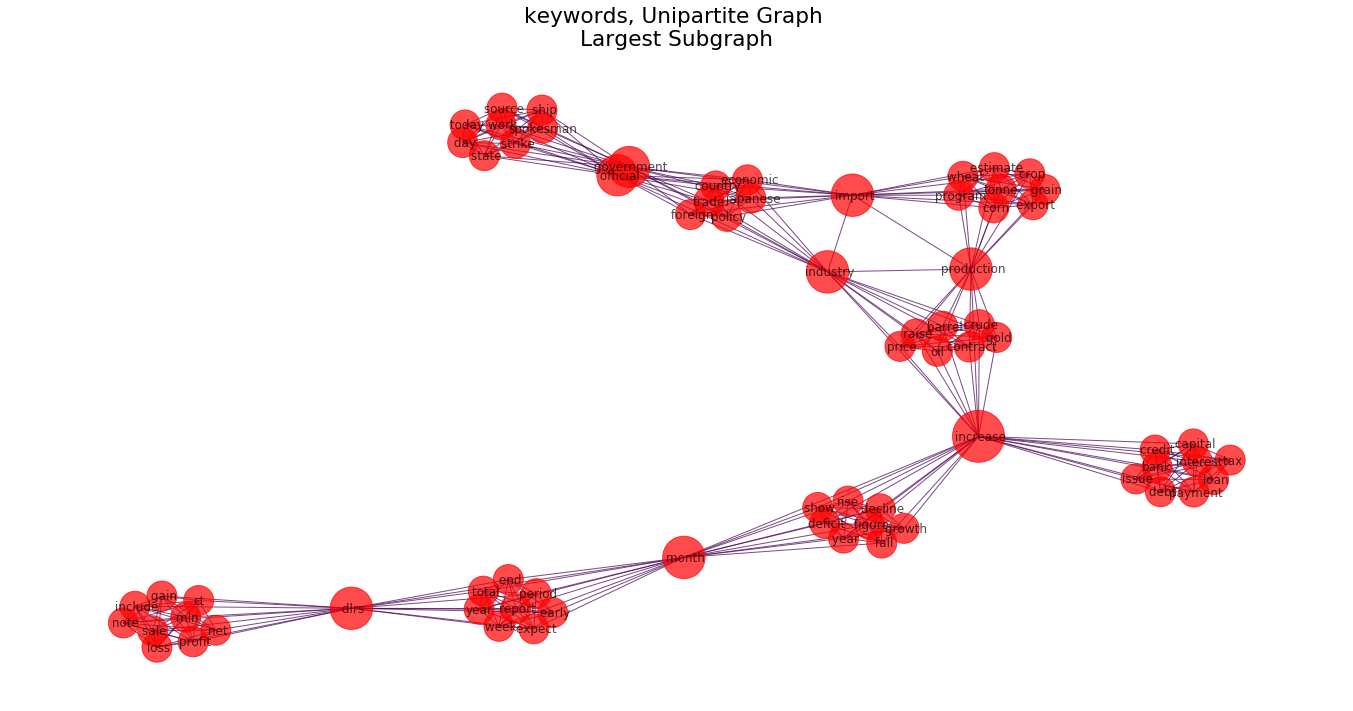

In [20]:
# Visualize the unipartite graph to identify relationships between keywords
title = 'keywords, Unipartite Graph \nLargest Subgraph'
convert_bipartite_plot_unipartite(Keywords, title)

# Island Method

In [21]:
# Function to trim nodes based on degree
def trim_nodes(graph, degree=1):
    
    graph_copy = graph.copy() # Copy graph so that original is not altered adn to avoid error below
    
    for (node, val) in graph.degree(): # Must be run on original graph or dictionary will change size during iteration
            if val < degree:
                graph_copy.remove_node(node)
    
    return graph_copy

# Function to trim edges based on weight
def trim_edges(graph, weight=1): 
    
    graph_copy=nx.Graph()
    
    for f, to, edata in graph.edges(data=True): 
        if edata['weight'] > weight:
            graph_copy.add_edge(f,to,**edata)
    
    return graph_copy

# Function to implement island method
def island_method(graph, func=trim_nodes, iterations=5):

    degree = [val for (node, val) in graph.degree()]
    
    mn=int(min(degree))
    mx=int(max(degree))
    step=int((mx-mn)/(iterations))
    
    # List of threshold and trimmed graph pairs
    islands = [[deg_threshold, func(graph, deg_threshold)] for deg_threshold in range(mn,mx,step)]

    # For every island, add number of nodes and subgraphs
    for i in islands:
        g_trim = i[1]
        num_nodes = len(g_trim.nodes)
        i.append(num_nodes)
        num_subgraphs = len([g_trim.subgraph(c) for c in nx.connected_components(g_trim)])
        i.append(num_subgraphs)
    
    return pd.DataFrame(islands, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])

# Function to plot trimmed graph based on island method iteration
def draw_islands(df, i):
    
    warnings.filterwarnings('ignore')
    
    G = df['Graph'][i]
    node_size = [G.degree(v)*100 for v in G] #sizes nodes according to connectedness in first iteration
    
    # Set node color
    if G.graph['name'] == 'Best_Topic':
        node_color = 'blue'
    elif G.graph['name'] == 'Keywords':
        node_color = 'red'
    else: 
        node_color = 'r'
    
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = (24,12)
    plt.axis('off')
    title = str('Island Method Iteration # %d\nThreshold for Inclusion: %s Shared Keywords in Dataset' % (i, df['Degree Threshold'][i]))
    plt.title(title)
    
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, 
                     pos=pos, 
                     node_size=node_size, 
                     node_color=node_color,
                     with_labels=False, 
                     alpha=0.8)
    nx.draw_networkx_labels(G, pos=pos, alpha = 0.9)

In [22]:
# Assess optimal degree threshold for node trimming of keywords network
act_islands = island_method(Keywords, func=trim_nodes, iterations=9)
act_islands.drop(['Graph'], axis=1).style.hide_index()

Degree Threshold,Number of Nodes,Number of Subgraphs
9,71,1
11,8,1
13,8,1
15,8,1
17,8,1
19,1,1
21,1,1
23,1,1
25,1,1


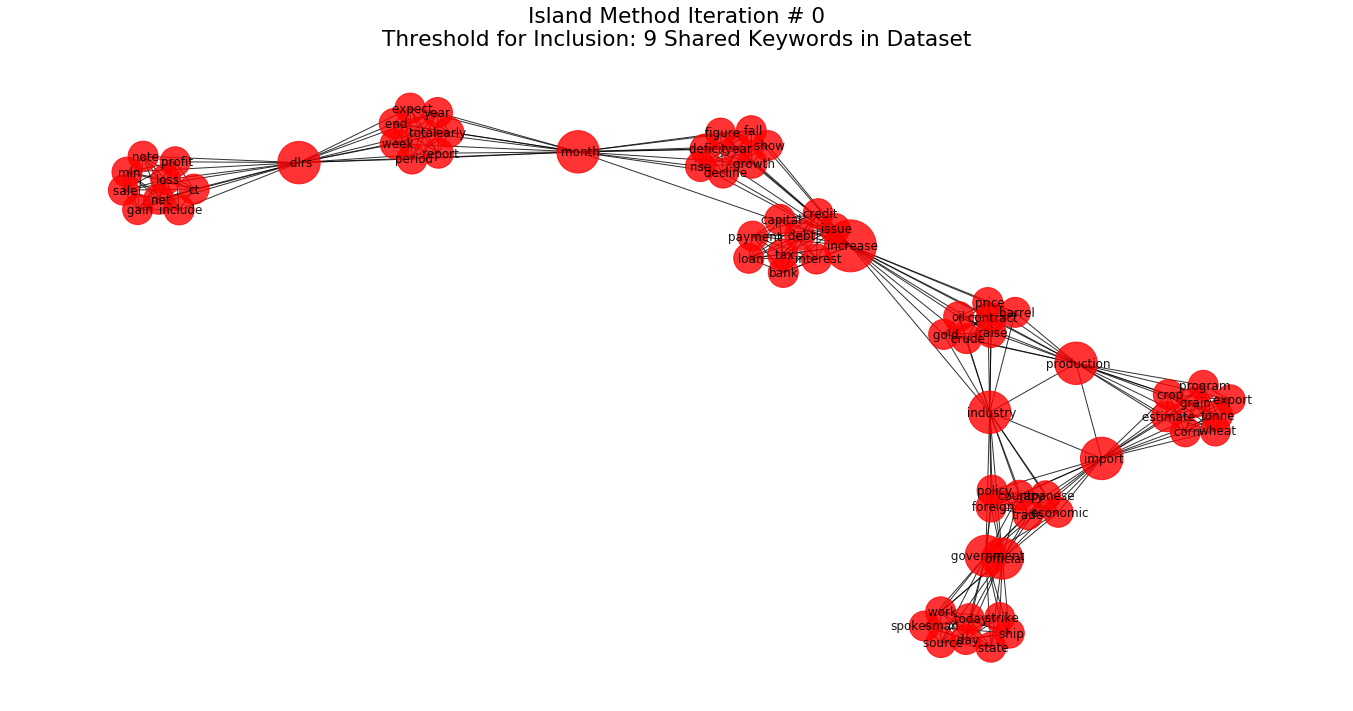

In [23]:
# Plot the 20+ degree threshold actor network
draw_islands(act_islands, 0)


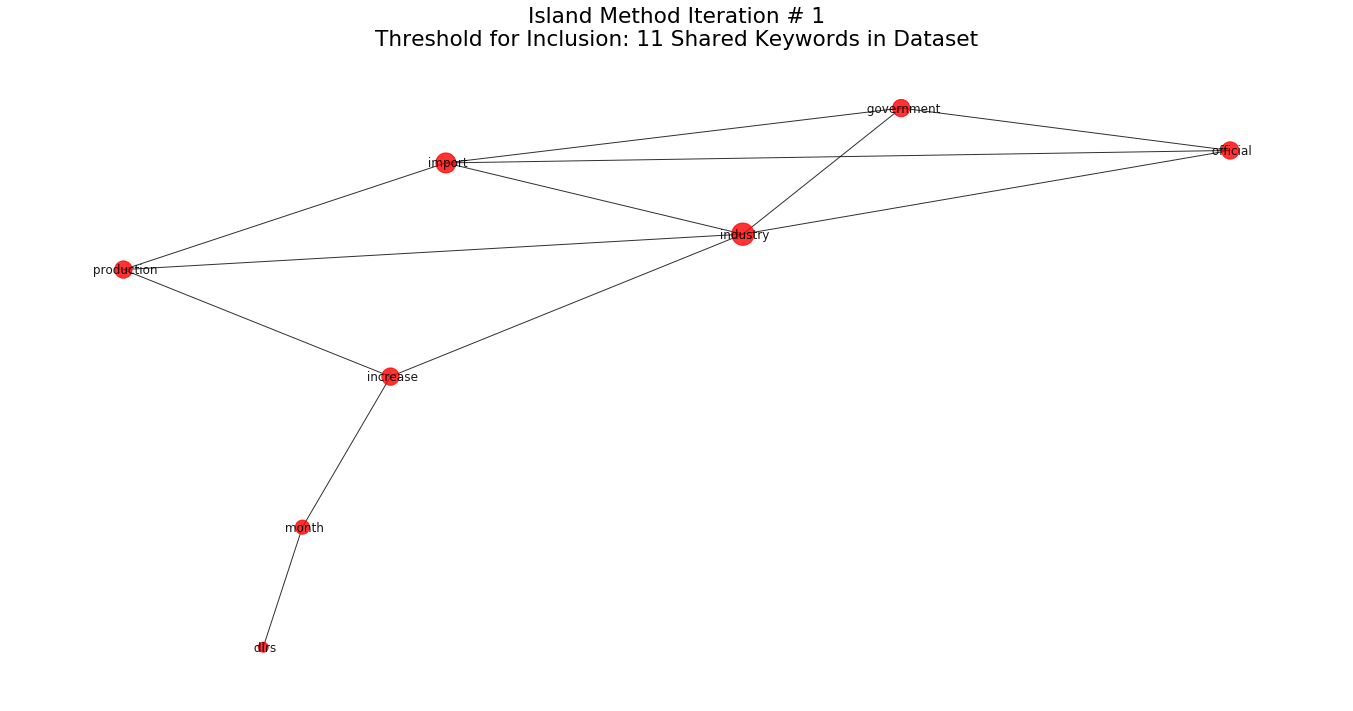

In [25]:
# Plot the 20+ degree threshold actor network
draw_islands(act_islands, 1)

We decided to utilize the largest keyword subgraph for further analysis.

In [26]:
# Designate trimmed movie subgraph for analysis and visualization
movies_16 = act_islands['Graph'][0]
movies_16.graph["name"] = "Keywords with 9 or more shared topics"
print(nx.info(movies_16))

Name: Keywords with 9 or more shared topics
Type: Graph
Number of nodes: 71
Number of edges: 359
Average degree:  10.1127


### Centrality

In [27]:

# Function to calculate centrality metrics
def get_metrics(graph):
    
    # Create dataframe to store centrality metrics
    names = [n for n in graph.nodes()]
    metrics = pd.DataFrame({'name': names})
    
    # Calculate degree centrality
    degree = nx.degree(graph)
    metrics['degree'] = [degree[n] for n in graph.nodes()]
    
    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(graph)
    metrics['betweenness'] = [betweenness[n] for n in graph.nodes()]
    
    # Calculate closeness centrality
    closeness = nx.closeness_centrality(graph)
    metrics['closeness'] = [closeness[n] for n in graph.nodes()]
    
    # Calculate eigenvector centrality
    eigen = nx.eigenvector_centrality_numpy(graph)
    metrics['eigen'] = [eigen[n] for n in graph.nodes()]
    
    return metrics

# Function to boxplot centrality metrics
def plot_metrics(graph):
    
    # Calculate centrality metrics
    metrics = get_metrics(graph)
    
    # Generate plot
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (24,12)
    plt.rcParams.update({'font.size': 18})
    metrics.plot.box(subplots=True)
    plt.suptitle(str('Centrality Metrics \n{}').format(graph.graph['name']))
    plt.show()

Here, we take a look at betweeness centrality. Betweenness centrality measures how a given node helps connect others in the network. It reflects a node's ability to act as a bridge.

In [28]:

# Generate keyword centrality metrics for analysis
metrics = get_metrics(movies_16)

# Output top 25 keywords by degree
metrics.sort_values(by=['degree'], ascending=False).head(n=25).style.hide_index()

name,degree,betweenness,closeness,eigen
increase,27,0.607453,0.538462,0.283939
import,18,0.057971,0.378378,0.240263
dlrs,18,0.227329,0.353535,0.052488
production,18,0.156522,0.445860,0.242082
industry,18,0.303934,0.469799,0.276482
month,18,0.387578,0.451613,0.125248
government,17,0.101035,0.376344,0.211867
official,17,0.101035,0.376344,0.211867
tax,9,0.000000,0.366492,0.085148
figure,9,0.000000,0.404624,0.094399


Here, we take a look at degree centrality. Degree centrality measures the direct links a node has to others in the network.
From the perspective of the movie industry, this measure highlights actors who co-starred the most with other actors in teh network.

In [29]:
# Output top 25 keywords by betweenness
metrics.sort_values(by=['betweenness'], ascending=False).head(n=25).style.hide_index()

name,degree,betweenness,closeness,eigen
increase,27,0.607453,0.538462,0.283939
month,18,0.387578,0.451613,0.125248
industry,18,0.303934,0.469799,0.276482
dlrs,18,0.227329,0.353535,0.052488
production,18,0.156522,0.445860,0.242082
government,17,0.101035,0.376344,0.211867
official,17,0.101035,0.376344,0.211867
import,18,0.057971,0.378378,0.240263
figure,9,0.000000,0.404624,0.094399
tax,9,0.000000,0.366492,0.085148


## Conclusion

### Summary

In this project we combined techniques from topic modeling to identify the topics of nearly 11,000 articles in the Reuters news corpus, and analyzed those topics to see how articles are thematically related to one another.

We used NLTK, Spacy, Gensim, and MALLET to generate and tuned two unsupervised models, optimizing the number of topics - a key hyperparameter - in our models based on topic coherence (Gensim: 9 topics, .44 coherence / MALLET: 14 topics, .537 coherence).

We compared the topics generated by the Gensim and MALLET models - with each other, and against the 90 labeled categories included in the Reuters corpus. MALLET's topics offered more precise and relevant keywords and were observably more thematically coherent. They also did not lead to the long tail of category classification, in which 28 topics comprised less than .1% of the corpus.

We chose the MALLET model over Gensim model given its higher coherence and tighter, more interpretable topics. Employing MALLET was a stretch goal for this project, and the extra proved worth it.

We used graph visualization and degree centrality to identify the most dominant topic in the entire corpus, which were 'increase,' 'import,' 'industry,' etc. From the weighted edges of the graph, we selected the top five most similar articles as ranked by their likelihood distribution. We assume what the best topics are based on the connected keywords. For example, 

### Additional Findings

Like other machine learning models, topic models can be evaluted based on hold-out likelihood - in this case, the models' ability to predict words in a given unseen text based on topics. However, the predictive power of a metric like perplexity can prioritize model complexity over interpretability. (['Applications of Topic Models'](https://mimno.infosci.cornell.edu/papers/2017_fntir_tm_applications.pdf)). 

Interpretation is a key requirement for many topic models use cases. The concept of topic coherence is premised on the idea that word co-occurence statistics demonstrate relationships between words, and that this signals thematic coherence of a topic (['Interpretable Machine Learning: Lessons from Topic Modeling'](https://cmci.colorado.edu/~mpaul/files/chi16hcml_interpretable.pdf). In this project, our qualitative preference for MALLET over Gensim keywords corresponds to a higher measure of coherence.

While we used coherence to tune the model, the literature suggests that human evaluation and feedback can also be important, and that crowdsouced consensus can be used to calibrate model performance. (['In Search of Coherence and Consensus: Measuring the Interpretability of Staistical Topics'](http://www.jmlr.org/papers/volume18/17-069/17-069.pdf)). We can envision validating whether an LDA-generated topic or a labeled category is preferable to identify the theme of an article by testing with human subjects.

### Potential Future Avenues

- Improve the performance of topic modeling using provided labeling article topic labels using an supervised implementation supporting multiple labels ([LLDA](http://www.mimno.org/articles/labelsandpatterns/))
- Consider implementing an HDP model to use posterior inference to guide the number of topics. ([Hierarchical Dirichlect Process (HDP)](https://medium.com/square-corner-blog/topic-modeling-optimizing-for-human-interpretability-48a81f6ce0ed))
- Alternatively, to perform network analysis of the relationships between authors and topics, consider replacing the Reuters corpus with another source of news articles with authorship labels
- Consider implementing a community detection approach to topic modeling like Hierarchical Stochastic Block Modeling ([hSBM](https://advances.sciencemag.org/content/4/7/eaaq1360))

## YouTube

First presenter (Jeremy O'Brien):

In [2]:
YouTubeVideo('/66il-Xy0CNw')

Second presenter (Mael Illien):

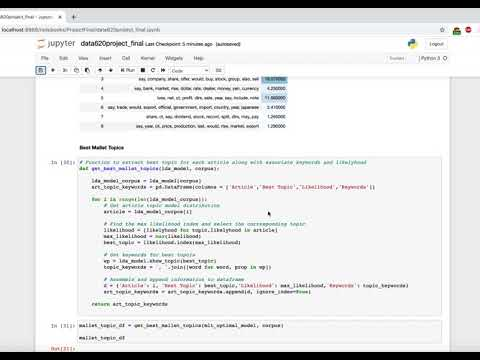

In [3]:
YouTubeVideo('Yh7Tex2Im9s')

Third presenter (Vanita Thompson):

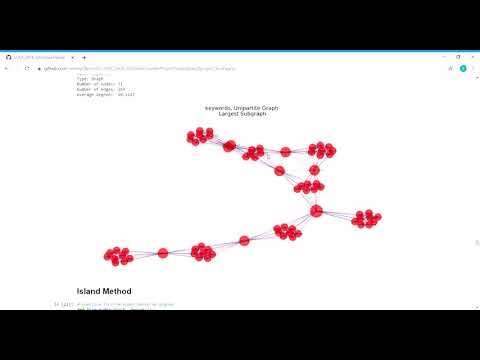

In [4]:
YouTubeVideo('m07GD7hdAcw')

## Appendix

### pyLDAvis Topic Prevalence and Distribution 

In this visualization, we can analyze saliency (how much the term tells you about the topic), relevance (a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic). The size of the bubble indicates the importance of the topics, relative to the data.

Unfortunately, this visualization only works on the gensim model but it is a great tool for exploration of the topic model. 

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(gs_optimal_model, corpus, id2word)
vis

NameError: name 'pyLDAvis' is not defined

## References

### Topic Modeling

- Definition: https://en.wikipedia.org/wiki/Topic_mode
- Gibbs EM (paper): http://dirichlet.net/pdf/wallach06topic.pdf 
- Tutorial (R): https://cfss.uchicago.edu/notes/topic-modeling/
- Bioinformatic applications: https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8
- Applications: https://mimno.infosci.cornell.edu/papers/2017_fntir_tm_applications.pdf
- Phrase and topic discovery for IR (paper): https://people.cs.umass.edu/~mccallum/papers/tng-icdm07.pdf
- Example: https://hookedondata.org/topic-modeling-the-new-york-times-and-trump/

### LDA (Latent Dirichlet Allocation)

- Defintiion: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
- Definition: https://en.wikipedia.org/wiki/Dirichlet_distribution
- Tutorial: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
- Tutorial: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158
- Tutorial with pyLDAviz: https://medium.com/@soorajsubrahmannian/extracting-hidden-topics-in-a-corpus-55b2214fc17d
- Training: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
- Tuning: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
- Tuning: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
- Importance of priors (paper): http://dirichlet.net/pdf/wallach09rethinking.pdf

### Perplexity, Coherence, Interpretability

- Definition: https://en.wikipedia.org/wiki/Perplexity 
- Perplexity math: http://qpleple.com/perplexity-to-evaluate-topic-models/
- Optimizing perplexity: https://cfss.uchicago.edu/notes/topic-modeling/ 
- Coherence, intrinsic / extrinsic measures and math: http://qpleple.com/topic-coherence-to-evaluate-topic-models/ 
- Automatic coherence evaluation (paper): https://mimno.infosci.cornell.edu/info6150/readings/N10-1012.pdf (automatic topic coherence evaluation)
- Interpretability: https://cmci.colorado.edu/~mpaul/files/chi16hcml_interpretable.pdf (interpretability)
- Interpretability: https://www.researchgate.net/publication/327888131_Four_Keys_to_Topic_Interpretability_in_Topic_Modeling_7th_International_Conference_AINL_2018_St_Petersburg_Russia_October_17-19_2018_Proceedings
- Optimizing interpretability: https://medium.com/square-corner-blog/topic-modeling-optimizing-for-human-interpretability-48a81f6ce0ed
- Interpretability (paper): https://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models.pdf
- Consensus (paper): http://www.jmlr.org/papers/volume18/17-069/17-069.pdf
- Gensim cohernece function: https://radimrehurek.com/gensim/models/coherencemodel.html

### Gensim (Generate Similar)

- Gensim overview: https://radimrehurek.com/gensim/about.html
- LDA model: https://radimrehurek.com/gensim/models/ldamodel.html
- Tutorial: https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/
- Tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- Tutorial https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
- Tutorial: https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html
- Tutorial: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

### Spacy

- Overview: https://spacy.io/
- Code repository: https://github.com/explosion/spacy-models
- Tutorial: https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/
- Tutorial: https://medium.com/@AravindR07/nlp-using-spacy-and-topic-modeling-using-gensim-python-42c4574830d
- Tutorial: https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619

### MALLET (MAchine Learning for LanguagE Toolkit

- Overview: http://mallet.cs.umass.edu/topics.php
- Gensim wrapper: https://radimrehurek.com/gensim/models/wrappers/ldamallet.html
- Code repository: https://github.com/ANRChapitres/topic_modelling_mallet
- Tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/


### Text Network Analysis

- Topic model network approach (paper): https://advances.sciencemag.org/content/4/7/eaaq1360
- Text network analysis (paper): https://noduslabs.com/wp-content/uploads/2019/06/InfraNodus-Paranyushkin-WWW19-Conference.pdf
- Community detection code repository: https://github.com/michal-pikusa/text-network-analysis
- hSBM code repository: https://github.com/martingerlach/hSB_Topicmodel/blob/master/TopSBM-tutorial.ipynb

### Other Methods

- Labelled LDA (LLDA): http://www.mimno.org/articles/labelsandpatterns/
- Hierarchical Dirichlet Process (HDP): http://mlg.eng.cam.ac.uk/tutorials/07/ywt.pdf
- Hierarchical Stochastic Block Models (hSBM): https://github.com/martingerlach/hSBM_Topicmodel